In [1]:
# https://sentiwiki.copernicus.eu/web/s2-products

In [2]:
# or should this be L1C data
# https://sentinels.copernicus.eu/web/sentinel/sentinel-data-access/sentinel-products/sentinel-2-data-products/collection-1-level-1c
# ?

In [3]:
import json
import numpy as np
import pandas as pd
import random
import requests
import rasterio
import itertools
import matplotlib.image
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from pathlib import Path
from settings import username, password
from rasterio.windows import Window


In [4]:
catalogue_odata_url = "https://catalogue.dataspace.copernicus.eu/odata/v1"

collection_name = "SENTINEL-2"
product_type = "S2MSI2A" # "S2MSI1C"
max_cloud_cover = 1
#corners = list(itertools.product(["20.888443", "21.124649"], ["52.169721", "52.271099"]))
corners = list(itertools.product(["23.0", "24.5"], ["56.5", "57.2"]))
poly = [" ".join(corners[i]) for i in [0, 2, 3, 1, 0]]
aoi = f"POLYGON(({",".join(poly)}))"
search_period_start = "2023-06-01T00:00:00.000Z"
search_period_end = "2023-06-10T00:00:00.000Z"


In [5]:
search_query = f"{catalogue_odata_url}/Products?$filter=Collection/Name eq '{collection_name}' and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/OData.CSC.StringAttribute/Value eq '{product_type}') and OData.CSC.Intersects(area=geography'SRID=4326;{aoi}') and ContentDate/Start gt {search_period_start} and ContentDate/Start lt {search_period_end}"

print(f"""\n{search_query.replace(' ', "%20")}\n""")



https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20'SENTINEL-2'%20and%20Attributes/OData.CSC.StringAttribute/any(att:att/Name%20eq%20'productType'%20and%20att/OData.CSC.StringAttribute/Value%20eq%20'S2MSI2A')%20and%20OData.CSC.Intersects(area=geography'SRID=4326;POLYGON((23.0%2056.5,24.5%2056.5,24.5%2057.2,23.0%2057.2,23.0%2056.5))')%20and%20ContentDate/Start%20gt%202023-06-01T00:00:00.000Z%20and%20ContentDate/Start%20lt%202023-06-10T00:00:00.000Z



In [6]:
auth_server_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
data = {
    "client_id": "cdse-public",
    "grant_type": "password",
    "username": username,
    "password": password,
}

response = requests.post(auth_server_url, data=data, verify=True, allow_redirects=False)
access_token = json.loads(response.text)["access_token"]


In [7]:
# filter by cloud coverage
search_query = f"{search_query} and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value le {max_cloud_cover})"
print(f"""\n{search_query.replace(' ', "%20")}\n""")

response = requests.get(search_query).json()
result = pd.DataFrame.from_dict(response["value"])

result.head(3)



https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20'SENTINEL-2'%20and%20Attributes/OData.CSC.StringAttribute/any(att:att/Name%20eq%20'productType'%20and%20att/OData.CSC.StringAttribute/Value%20eq%20'S2MSI2A')%20and%20OData.CSC.Intersects(area=geography'SRID=4326;POLYGON((23.0%2056.5,24.5%2056.5,24.5%2057.2,23.0%2057.2,23.0%2056.5))')%20and%20ContentDate/Start%20gt%202023-06-01T00:00:00.000Z%20and%20ContentDate/Start%20lt%202023-06-10T00:00:00.000Z%20and%20Attributes/OData.CSC.DoubleAttribute/any(att:att/Name%20eq%20'cloudCover'%20and%20att/OData.CSC.DoubleAttribute/Value%20le%201)



,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,8b62c4bc-b821-41a2-92bb-22e85ac8f10a,S2B_MSIL2A_20230608T093549_N0509_R036_T34VFJ_2...,application/octet-stream,967112358,2023-06-08T14:32:22.710000Z,2023-06-08T14:38:40.815723Z,2023-06-12T01:15:02.009415Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/06/08/S2B_MSIL...,"[{'Value': 'efe01d49fb0e7060348d8bd0ffc67305',...","{'Start': '2023-06-08T09:35:49.024000Z', 'End'...",geography'SRID=4326;POLYGON ((22.6793206704832...,"{'type': 'Polygon', 'coordinates': [[[22.67932..."
1,application/octet-stream,f67b503f-f319-42f2-8918-7ca607f79571,S2B_MSIL2A_20230608T093549_N0509_R036_T35VLD_2...,application/octet-stream,1093965218,2023-06-08T14:35:31.749000Z,2023-06-08T14:42:16.490001Z,2023-06-21T12:40:46.556202Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/06/08/S2B_MSIL...,"[{'Value': '5ec6537f5a82c316be0de49822037ef8',...","{'Start': '2023-06-08T09:35:49.024000Z', 'End'...",geography'SRID=4326;POLYGON ((23.6438298900325...,"{'type': 'Polygon', 'coordinates': [[[23.64382..."


In [8]:
product_identifier = result.iloc[0, 1]
product_name = result.iloc[0, 2]

session = requests.Session()
session.headers["Authorization"] = f"Bearer {access_token}"


In [9]:
url = f"{catalogue_odata_url}/Products({product_identifier})/Nodes({product_name})/Nodes(MTD_MSIL2A.xml)/$value"

print(url)

response = session.get(url, allow_redirects=False)
while response.status_code in (301, 302, 303, 307):
    url = response.headers["Location"]
    response = session.get(url, allow_redirects=False)
    print(response)

file = session.get(url, verify=False, allow_redirects=True)

print(file)

outfile = Path.home() / f"Projs/bulbulis/MTD_MSIL2A.xml"
outfile.write_bytes(file.content)


https://catalogue.dataspace.copernicus.eu/odata/v1/Products(8b62c4bc-b821-41a2-92bb-22e85ac8f10a)/Nodes(S2B_MSIL2A_20230608T093549_N0509_R036_T34VFJ_20230608T112304.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>


54719

In [10]:
tree = ET.parse(str(outfile))
root = tree.getroot()

band_location = []
band_location.append(f"{product_name}/{root[0][0][12][0][0][2].text}.jp2".split("/"))
band_location.append(f"{product_name}/{root[0][0][12][0][0][1].text}.jp2".split("/"))
band_location.append(f"{product_name}/{root[0][0][12][0][0][0].text}.jp2".split("/"))


In [11]:
band_location

[['S2B_MSIL2A_20230608T093549_N0509_R036_T34VFJ_20230608T112304.SAFE',
  'GRANULE',
  'L2A_T34VFJ_A032666_20230608T093840',
  'IMG_DATA',
  'R10m',
  'T34VFJ_20230608T093549_B04_10m.jp2'],
 ['S2B_MSIL2A_20230608T093549_N0509_R036_T34VFJ_20230608T112304.SAFE',
  'GRANULE',
  'L2A_T34VFJ_A032666_20230608T093840',
  'IMG_DATA',
  'R10m',
  'T34VFJ_20230608T093549_B03_10m.jp2'],
 ['S2B_MSIL2A_20230608T093549_N0509_R036_T34VFJ_20230608T112304.SAFE',
  'GRANULE',
  'L2A_T34VFJ_A032666_20230608T093840',
  'IMG_DATA',
  'R10m',
  'T34VFJ_20230608T093549_B02_10m.jp2']]

In [12]:
# does this not cost credits?
bands = []
for band_file in band_location:
    url = f"{catalogue_odata_url}/Products({product_identifier})/{"/".join([f"Nodes({b})" for b in band_file])}/$value"
    print(url)
    response = session.get(url, allow_redirects=False)
    while response.status_code in (301, 302, 303, 307):
        url = response.headers["Location"]
        response = session.get(url, allow_redirects=False)
    file = session.get(url, verify=False, allow_redirects=True)
    
    outfile = Path.home() / f"Projs/bulbulis/{band_file[-1]}"
    outfile.write_bytes(file.content)
    bands.append(str(outfile))
    print("Saved:", band_file[-1])
    

https://catalogue.dataspace.copernicus.eu/odata/v1/Products(8b62c4bc-b821-41a2-92bb-22e85ac8f10a)/Nodes(S2B_MSIL2A_20230608T093549_N0509_R036_T34VFJ_20230608T112304.SAFE)/Nodes(GRANULE)/Nodes(L2A_T34VFJ_A032666_20230608T093840)/Nodes(IMG_DATA)/Nodes(R10m)/Nodes(T34VFJ_20230608T093549_B04_10m.jp2)/$value


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFJ_20230608T093549_B04_10m.jp2
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(8b62c4bc-b821-41a2-92bb-22e85ac8f10a)/Nodes(S2B_MSIL2A_20230608T093549_N0509_R036_T34VFJ_20230608T112304.SAFE)/Nodes(GRANULE)/Nodes(L2A_T34VFJ_A032666_20230608T093840)/Nodes(IMG_DATA)/Nodes(R10m)/Nodes(T34VFJ_20230608T093549_B03_10m.jp2)/$value


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFJ_20230608T093549_B03_10m.jp2
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(8b62c4bc-b821-41a2-92bb-22e85ac8f10a)/Nodes(S2B_MSIL2A_20230608T093549_N0509_R036_T34VFJ_20230608T112304.SAFE)/Nodes(GRANULE)/Nodes(L2A_T34VFJ_A032666_20230608T093840)/Nodes(IMG_DATA)/Nodes(R10m)/Nodes(T34VFJ_20230608T093549_B02_10m.jp2)/$value


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFJ_20230608T093549_B02_10m.jp2


In [13]:
bands


['/Users/kristaps/Projs/bulbulis/T34VFJ_20230608T093549_B04_10m.jp2',
 '/Users/kristaps/Projs/bulbulis/T34VFJ_20230608T093549_B03_10m.jp2',
 '/Users/kristaps/Projs/bulbulis/T34VFJ_20230608T093549_B02_10m.jp2']

In [14]:
%matplotlib inline

# Crop the images to random 1000x1000 patch
xsize, ysize = 1000, 1000
#xoff, yoff, xmax, ymax = 0, 0, 0, 0
xoff = 9246 # locking for the time being
yoff = 7990
xmax = 9980
ymax = 9980
n = 2

for band_file in bands:
    full_band = rasterio.open(band_file, driver="JP2OpenJPEG")
    if xmax == 0:
        xmin, xmax = 0, full_band.width - xsize
    if ymax == 0:
        ymin, ymax = 0, full_band.height - ysize
    if xoff == 0:
        xoff, yoff = random.randint(xmin, xmax), random.randint(ymin, ymax)
    window = Window(xoff, yoff, xsize, ysize)
    transform = full_band.window_transform(window)
    profile = full_band.profile
    crs = full_band.crs
    profile.update({"height": xsize, "width": ysize, "transform": transform})
    with rasterio.open(
        f"{Path.home()}/Projs/bulbulis/patch_band_{n}.jp2", "w", **profile
    ) as patch_band:
        # Read the data from the window and write it to the output raster
        patch_band.write(full_band.read(window=window))
    print(f"Patch for band {n} created")
    n += 1


Patch for band 2 created
Patch for band 3 created
Patch for band 4 created


In [15]:
# Read the patch files
band2 = rasterio.open(f"{Path.home()}/Projs/bulbulis/patch_band_2.jp2", driver="JP2OpenJPEG")  # blue
band3 = rasterio.open(f"{Path.home()}/Projs/bulbulis/patch_band_3.jp2", driver="JP2OpenJPEG")  # green
band4 = rasterio.open(f"{Path.home()}/Projs/bulbulis/patch_band_4.jp2", driver="JP2OpenJPEG")  # red

red = band2.read(1)
green = band3.read(1)
blue = band4.read(1)


In [16]:
# https://github.com/sentinel-hub/custom-scripts/tree/main/sentinel-2/l2a_optimized
rgb = np.stack((red, green, blue), axis=2)

maxR = 3.0 # max reflectance
midR = 0.13
sat = 1.2


In [17]:
def clip(s):
    return max(0, min(1, s))
    

def adj(a, tx, ty, maxC):
    ar = clip(a / maxC)
    return ar * (ar * (tx / maxC + ty - 1) - ty) / (ar * (2 * tx / maxC - 1) - tx / maxC)


gOff = 0.01
gamma = 1.8
gOffPow = gOff**gamma
gOffRange = ((1 + gOff)**gamma) - gOffPow


def adjGamma(b):
    return (((b + gOff)**gamma) - gOffPow) / gOffRange


def sAdj(a):
    return adjGamma(adj(a, midR, 1, maxR))


def satEnh(e):
    r = sAdj(e[0]/10000)
    g = sAdj(e[1]/10000)
    b = sAdj(e[2]/10000)
    avgS = (r + g + b) / 3.0 * (1 - sat)
    return [clip(avgS + r * sat), clip(avgS + g * sat), clip(avgS + b * sat)] # why do I clip twice?


def sRGB(c):
    return (12.92 * c) if c <= 0.0031308 else (1.055 * (c**0.41666666666) - 0.055)


def evaluatePixel(e):
    enh = satEnh(e)
    return [sRGB(p) for p in enh]


In [18]:
nRGB = np.apply_along_axis(satEnh, 2, rgb)


Saved as: /Users/kristaps/Projs/bulbulis/T34VFJ_20230608T093549_B02_10m.jp2


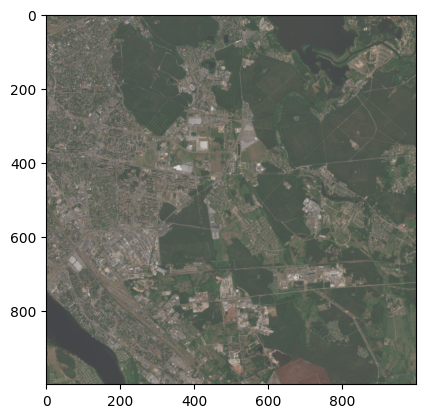

In [19]:
# Normalize the pixel values and apply gain
red_n = nRGB[:, :, 0] #np.clip(red * gain / 10000, 0, 1)
green_n = nRGB[:, :, 1] #np.clip(green * gain / 10000, 0, 1)
blue_n = nRGB[:, :, 2] #np.clip(blue * gain / 10000, 0, 1)

# Create composite image
rgb_composite_n = np.dstack((red_n, green_n, blue_n))

# Display image
plt.imshow(rgb_composite_n)

# Save image to file
matplotlib.image.imsave(f"{Path.home()}/Projs/bulbulis/Sentinel2_true_color_enh.jpeg", rgb_composite_n)
print("Saved as:", outfile)


Saved as: /Users/kristaps/Projs/bulbulis/T34VFJ_20230608T093549_B02_10m.jp2


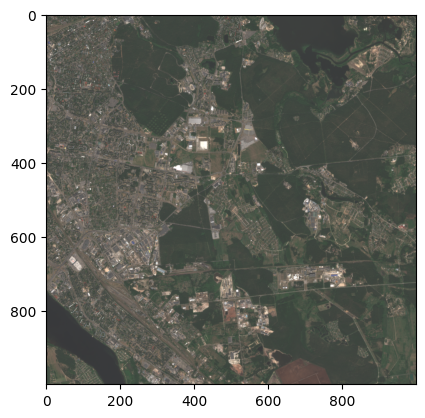

In [21]:
gain = 2

# Normalize the pixel values and apply gain
red_n = np.clip(red * gain / 10000, 0, 1)
green_n = np.clip(green * gain / 10000, 0, 1)
blue_n = np.clip(blue * gain / 10000, 0, 1)

# Create composite image
rgb_composite_n = np.dstack((red_n, green_n, blue_n))

# Display image
plt.imshow(rgb_composite_n)

# Save image to file
matplotlib.image.imsave(f"{Path.home()}/Projs/bulbulis/Sentinel2_true_color_base.jpeg", rgb_composite_n)
print("Saved as:", outfile)


In [22]:
# ndvi = ((b08 - b04) / (b08 + b04))
# NDVI > 0.7 => forest